In [1]:
from pillow_heif import register_heif_opener
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

/Users/matsuuraasuka/miniconda3/envs/wp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading
## Partition PDF tables, text, and images

We use Unstructured to partition it .

In [2]:
# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )

# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    # print the number of elements
    print("Number of tables:", len(tables))
    # print each element
    for table in tables:
        print(table)
    print("Number of texts:", len(texts))
    for text in texts:
        print(text, "\n")
    return texts, tables


# File path
fpath = "../"
fname = "docs/delta.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)
print(texts_4k_token)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of tables: 1
BA] ik ASEH 100 VAC - 240 VAC 10 SH) Sire 15-10A i] GAR 50 Hz/ 60 Hz nS Bse 40 - 150 kV a Ses 10 - 400 mA LH SB itis elas 42 kV / 100 mAs » 125 kV / 32 mAs > 32 kW/ 100 ms max Bums 1 - 6300 ms HI < 1kV @ 110 kV BS)Sir ae tt AEC AB HUB PAK 3242 DAP HUBER AK RUS 24 VDC / 2A, 24 AC / 6A, 110 VAC / 2A or 220 VAC / 1A EAI TRE ROR APR 192 Preset, User Programmable RY (Rx Bxe) 630 x 370 x 400 mm a 60 kg Ratt IEC60601-1 3 edition with Amendment 1; IEC60601-2-54; ISO 14971:2007_2012_2016, IEC 62304 : 2006, Amd.1:2015, IEC60601-1-3 2008/Amd.1 : 2013 BURA IEC 60601-1-2 4" edition compliance
Number of texts: 2
Anew a

ea FH X 76 ie Be + a8 [a] ET) DR 442A / DMP-200 435)

|

= fon Tt

e SAMAR ARIRE AXGza ems

e SRERKGAMARE Feta ZEA Swett

o AACR SAIS «BRE aI RBG]

e 100-240 VAC BRIA ima AKS

o SRR SALE) IR mM EER SAA Mal AK

e 07384 AEC / DAP SSMalaxts - A(bE RACE

Bi

wh

FT (ER AROXH

Aree AT ASKER SVS Ree

DMP-200A 8A CteRRaS SAERAAMRal Fetal te AACE ASRRE THAMESRRAERS > SAUN

# Multi-vector retriever
Use multi-vector-retriever to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

## Text and Table summaries
We will use GPT-4 to produce table and, optionall, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv(".env")

# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    # Print the length and the content of the summaries
    print("Number of text summaries:", len(text_summaries))
    for text_summary in text_summaries:
        print(text_summary)
    print("Number of table summaries:", len(table_summaries))
    for table_summary in table_summaries:
        print(table_summary)
        
    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

Number of text summaries: 1
**Summary:**

Table details specifications for the DMP-200A device, including power requirements (100-240 VAC), dimensions (630mm x 370mm), and contact information for Delta (phone: +886-3-452-6107, email: X.RAY@deltaww.com). The document is dated February 2021.
Number of table summaries: 1
**Summary:** The table provides specifications for a medical device with input voltage of 100-240 VAC and frequency of 50/60 Hz. It operates at a base of 40-150 kV and a current range of 10-400 mA. Key parameters include maximum output of 32 kW for 100 ms, with a burn time range of 1-6300 ms. The device has multiple power supply options (24 VDC, 110 VAC, 220 VAC) and dimensions of 630 x 370 x 400 mm, weighing 60 kg. It complies with various IEC and ISO standards, including IEC 60601-1 and IEC 60601-1-2.


## Image summaries
We will use GPT-4o-mini to produce the image summaries.

We pass base64 encoded images

In [4]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o-mini", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    print(msg.content)
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

# fpath
figure_path = "../multiRAG/figures"
# Image summaries
img_base64_list, image_summaries = generate_img_summaries(figure_path)

Image of a white industrial equipment unit with the "DELTA" logo prominently displayed on the front. The unit has a smooth, clean design, likely a cooling or refrigeration device, with ventilation grilles on the side and adjustable feet for stability.
Icon of a hospital building with a cross symbol, set against a blue background. The image includes the Chinese characters for "hospital" at the bottom.
A smiling healthcare professional in a white coat interacts with a happy male patient in a medical office setting. The patient, wearing a white t-shirt, is seated, while the professional gestures towards him, suggesting a friendly consultation or examination. Medical equipment and a monitor are visible in the background.
Image of a rectangular electrical device with dimensions labeled: 630 mm (width), 370 mm (depth), and 400 mm (height). Features include input and output ports, ventilation grilles, and a caution symbol for electrical safety. The device has a plain white exterior.
Logo of D

In [5]:
print(image_summaries)

['Image of a white industrial equipment unit with the "DELTA" logo prominently displayed on the front. The unit has a smooth, clean design, likely a cooling or refrigeration device, with ventilation grilles on the side and adjustable feet for stability.', 'Icon of a hospital building with a cross symbol, set against a blue background. The image includes the Chinese characters for "hospital" at the bottom.', 'A smiling healthcare professional in a white coat interacts with a happy male patient in a medical office setting. The patient, wearing a white t-shirt, is seated, while the professional gestures towards him, suggesting a friendly consultation or examination. Medical equipment and a monitor are visible in the background.', 'Image of a rectangular electrical device with dimensions labeled: 630 mm (width), 370 mm (depth), and 400 mm (height). Features include input and output ports, ventilation grilles, and a caution symbol for electrical safety. The device has a plain white exterior

## Add to vectorstore
Add raw docs and doc summaries to Multi Vector Retriever:

Store the raw texts, tables, and images in the docstore.
Store the texts, table summaries, and image summaries in the vectorstore for efficient semantic retrieval.

In [6]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

# RAG
## Build retriever
We need to bin the retrieved doc(s) into the correct parts of the GPT-4V prompt template.

In [7]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image

from operator import itemgetter

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an expert of mechanics.\n"
            "You will be given a mixed of text, tables, and image(s).\n"
            "Use this information to answer to the user question. \n"
            "Say I don't know if you are not sure about the answer.\n\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """
    print("Creating multi-modal RAG chain")
    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": itemgetter("question") | retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

Creating multi-modal RAG chain


# Check
Examine retrieval; we get back images that are relevant to our question.

In [8]:
# Check retrieval
# query = "In the board topology, what is the location of the RESET pin?"
# query = "1896年和兩年後的X光技術的變遷?"
query = "DMP2000的外觀？顏色？"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [9]:
# Execute the chain with the query and retrieved documents
response = chain_multimodal_rag.invoke({
    # "context": docs,
    "question": query
})

# Display the response
print(response)

DMP2000的外觀是白色的。根據提供的圖片，這款設備的設計簡潔，主要以白色為主色調。


In [10]:
# print each doc
for doc in docs:
    print(doc)

Anew a

ea FH X 76 ie Be + a8 [a] ET) DR 442A / DMP-200 435)

|

= fon Tt

e SAMAR ARIRE AXGza ems

e SRERKGAMARE Feta ZEA Swett

o AACR SAIS «BRE aI RBG]

e 100-240 VAC BRIA ima AKS

o SRR SALE) IR mM EER SAA Mal AK

e 07384 AEC / DAP SSMalaxts - A(bE RACE

Bi

wh

FT (ER AROXH

Aree AT ASKER SVS Ree

DMP-200A 8A CteRRaS SAERAAMRal Fetal te AACE ASRRE THAMESRRAERS > SAUNXLHER a2 > LEYS » DMP-2O0RN Ti RARER « AVES eles FANG] GEAR AS eee iS FATA SSA AAS > AP ASZHF100-240 VAC SARS A » SBR AS RS) SIR» OU BRAEC / DAPI RASHE RAIL ERR BN AMR ADK °

HITE
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAF7A0IDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5


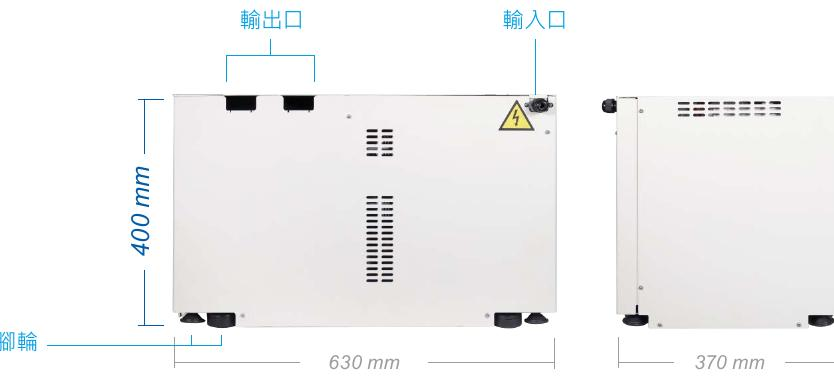

In [11]:
# We get back relevant images
plt_img_base64(docs[1])

## Sanity Check
Why does this work? Let's look back at the image that we stored ...


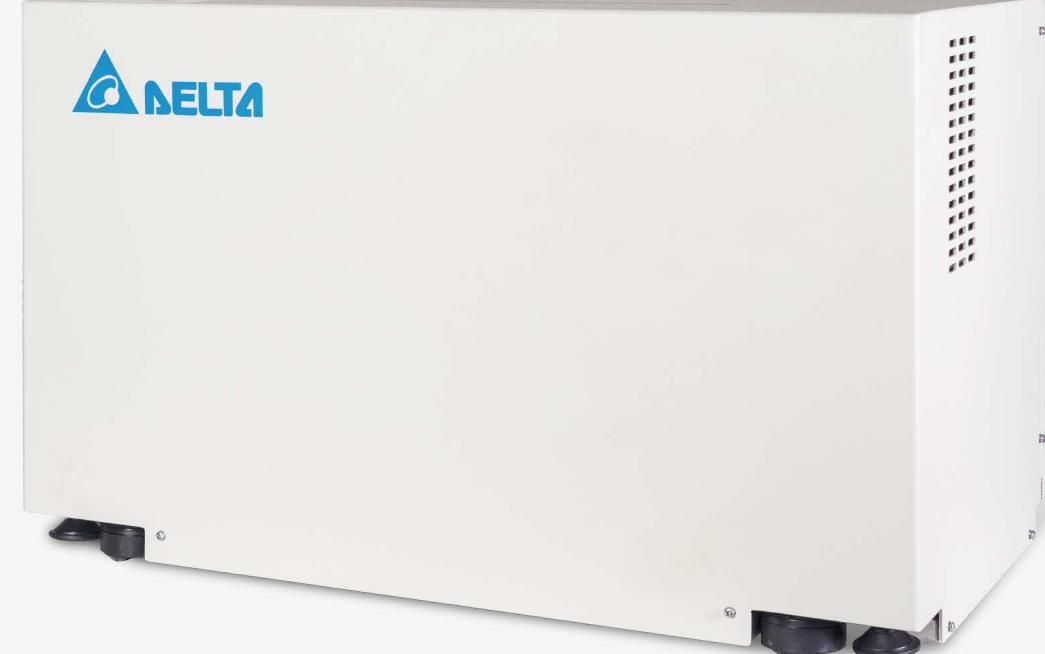

In [12]:
plt_img_base64(img_base64_list[0])

In [13]:
# Check retrieval
query2 = "我想請問哪些component有他的max current?"
docs2 = retriever_multi_vector_img.invoke(query2, limit=6)

len(docs2)
response2 = chain_multimodal_rag.invoke({
    # "context": docs,
    "question": query2
})
# Display the response
print(response2)

for doc in docs2:
    print(doc)

我不確定哪些元件有其最大電流。
BA] ik ASEH 100 VAC - 240 VAC 10 SH) Sire 15-10A i] GAR 50 Hz/ 60 Hz nS Bse 40 - 150 kV a Ses 10 - 400 mA LH SB itis elas 42 kV / 100 mAs » 125 kV / 32 mAs > 32 kW/ 100 ms max Bums 1 - 6300 ms HI < 1kV @ 110 kV BS)Sir ae tt AEC AB HUB PAK 3242 DAP HUBER AK RUS 24 VDC / 2A, 24 AC / 6A, 110 VAC / 2A or 220 VAC / 1A EAI TRE ROR APR 192 Preset, User Programmable RY (Rx Bxe) 630 x 370 x 400 mm a 60 kg Ratt IEC60601-1 3 edition with Amendment 1; IEC60601-2-54; ISO 14971:2007_2012_2016, IEC 62304 : 2006, Amd.1:2015, IEC60601-1-3 2008/Amd.1 : 2013 BURA IEC 60601-1-2 4" edition compliance
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAF7A0IDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTV

In [14]:
# Check retrieval
# query3 = "這個機器的RESET BUTTON在哪裡?"
query3 = "VUSSBMax是什麼?"
docs3 = retriever_multi_vector_img.invoke(query3, limit=6)

len(docs3)
response3 = chain_multimodal_rag.invoke({
    # "context": docs,
    "question": query3
})
# Display the response
print(response3)

for doc in docs3:
    print(doc)

I don't know what "VUSSBMax" is.
BA] ik ASEH 100 VAC - 240 VAC 10 SH) Sire 15-10A i] GAR 50 Hz/ 60 Hz nS Bse 40 - 150 kV a Ses 10 - 400 mA LH SB itis elas 42 kV / 100 mAs » 125 kV / 32 mAs > 32 kW/ 100 ms max Bums 1 - 6300 ms HI < 1kV @ 110 kV BS)Sir ae tt AEC AB HUB PAK 3242 DAP HUBER AK RUS 24 VDC / 2A, 24 AC / 6A, 110 VAC / 2A or 220 VAC / 1A EAI TRE ROR APR 192 Preset, User Programmable RY (Rx Bxe) 630 x 370 x 400 mm a 60 kg Ratt IEC60601-1 3 edition with Amendment 1; IEC60601-2-54; ISO 14971:2007_2012_2016, IEC 62304 : 2006, Amd.1:2015, IEC60601-1-3 2008/Amd.1 : 2013 BURA IEC 60601-1-2 4" edition compliance
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABYAEsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3